# Routing Demo (utilizing Pydantic)

### Usecase: LLM Call Router
* `START` gets a user input and passes it to `Router`
* `Router` then decides whether request is that for a poem, story or joke
* Then the `Router` will pass that input to respective node
* The `poem/ story/ joke node` generates requested content
* `END`

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq
llm = ChatGroq(model="gemma2-9b-it")

In [3]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from typing import TypedDict

# schema for structured output to use as a routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(description = "The next step in the routing process")

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

# create state class
class State(TypedDict):
    input: str
    decision: str
    output: str

In [4]:
def poem_call(state: State):
    """Write a poem"""
    result = llm.invoke(state["input"])
    return {"output":result.content}

def story_call(state: State):
    """Write a story"""
    result = llm.invoke(state["input"])
    return {"output":result.content}

def joke_call(state: State):
    """Write a joke"""
    result = llm.invoke(state["input"])
    return {"output":result.content}

def call_router(state: State):
    """Route the input to the appropriate node"""
    decision = router.invoke(
        [
            SystemMessage(content= "Route the input to Poem, Story or Joke based on the user request"),
            HumanMessage(content= state["input"]),
            ]
    )
    return {"decision":decision.step}

In [5]:
# condition function
def route_decision(state: State):
    if state["decision"] == "poem":
        return "poem_call"
    if state["decision"] == "story":
        return "story_call"
    if state["decision"] == "joke":
        return "joke_call"
    

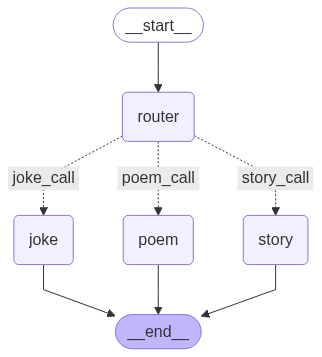

In [6]:
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image

builder = StateGraph(State)
builder.add_node("poem", poem_call)
builder.add_node("story", story_call)
builder.add_node("joke", joke_call)
builder.add_node("router", call_router)
builder.add_edge(START, "router")
builder.add_conditional_edges("router", route_decision, {"poem_call":"poem", "story_call":"story", "joke_call":"joke"})
builder.add_edge("poem", END)
builder.add_edge("story", END)
builder.add_edge("joke", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
state = {"input":"Write me a joke about Agentic AI System"}
result = graph.invoke(state)
result

{'input': 'Write me a joke about Agentic AI System',
 'decision': 'joke',
 'output': 'Why did the Agentic AI system fail its driving test? \n\nBecause it kept following the instructions of the road sign that said "Yield to Pedestrians" even when it was clearly in the right-of-way! It was too agentic! 😂  \n\n\nLet me know if you\'d like to hear another one! 🤖  \n\n'}